# Experiment 9: Implementing a Neural Network and Backpropagation from Scratch

## Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# TASK 1: Data Loading and Preprocessing 

In [3]:
# 1. Load Data
data = load_breast_cancer()
X = data.data
y = data.target

In [4]:
# 2. Inspect Data
print(f"\nData Shape:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature Names:")
print(data.feature_names)
print(f"\nTarget Names: {data.target_names}")
print(f"This is a binary classification problem: 0 (malignant) vs 1 (benign)")

# 3. Create Hold-Out Set (70/30 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nTrain-Validation Split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


Data Shape:
X shape: (569, 30)
y shape: (569,)

Feature Names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target Names: ['malignant' 'benign']
This is a binary classification problem: 0 (malignant) vs 1 (benign)

Train-Validation Split:
X_train shape: (398, 30)
X_val shape: (171, 30)
y_train shape: (398,)
y_val shape: (171,)


In [5]:
# 4. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nAfter Standardization:")
print(f"X_train_scaled mean: {X_train_scaled.mean():.6f}")
print(f"X_train_scaled std: {X_train_scaled.std():.6f}")


After Standardization:
X_train_scaled mean: -0.000000
X_train_scaled std: 1.000000


# TASK 2: 'From Scratch' Utilities (NumPy)

In [6]:
# 1. Activation Functions
def sigmoid(Z):
    """Compute sigmoid activation"""
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    """Compute ReLU activation"""
    return np.maximum(0, Z)

# 2. Activation Derivatives
def sigmoid_derivative(A):
    """Compute derivative of sigmoid given A = sigmoid(Z)"""
    return A * (1 - A)

def relu_derivative(Z):
    """Compute derivative of ReLU"""
    return (Z > 0).astype(float)

In [7]:
# 3. Loss Functions
def compute_bce_loss(Y, Y_hat, epsilon=1e-15):
    """Compute Binary Cross-Entropy Loss"""
    m = Y.shape[1]
    # Clip predictions to avoid log(0)
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)
    loss = -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m
    return loss

def compute_mse_loss(Y, Y_hat):
    """Compute Mean Squared Error Loss"""
    m = Y.shape[1]
    loss = np.sum((Y_hat - Y) ** 2) / m
    return loss

print("\nUtility functions implemented:")
print("✓ sigmoid(Z)")
print("✓ relu(Z)")
print("✓ sigmoid_derivative(A)")
print("✓ relu_derivative(Z)")
print("✓ compute_bce_loss(Y, Y_hat)")
print("✓ compute_mse_loss(Y, Y_hat)")

# Test the functions
print("\nTesting activation functions:")
test_Z = np.array([[-2, -1, 0, 1, 2]])
print(f"sigmoid({test_Z[0]}): {sigmoid(test_Z)[0]}")
print(f"relu({test_Z[0]}): {relu(test_Z)[0]}")


Utility functions implemented:
✓ sigmoid(Z)
✓ relu(Z)
✓ sigmoid_derivative(A)
✓ relu_derivative(Z)
✓ compute_bce_loss(Y, Y_hat)
✓ compute_mse_loss(Y, Y_hat)

Testing activation functions:
sigmoid([-2 -1  0  1  2]): [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
relu([-2 -1  0  1  2]): [0 0 0 1 2]


# TASK 3: 'From Scratch' ANN Classifier 

In [8]:
class MyANNClassifier:
    """
    A from-scratch implementation of a feedforward neural network for binary classification.
    Uses only NumPy for all computations.
    """
    
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        """
        Initialize the ANN classifier.
        
        Parameters:
        -----------
        layer_dims : list
            List specifying number of units in each layer [n_x, n_h1, n_h2, ..., 1]
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of training iterations
        loss : str
            Loss function to use ('bce' or 'mse')
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []
        self.L = len(layer_dims) - 1  # Number of layers (excluding input)
        
    def _initialize_parameters(self):
        """Initialize weights and biases for all layers"""
        np.random.seed(42)
        
        for l in range(1, self.L + 1):
            self.parameters_[f'W{l}'] = np.random.randn(
                self.layer_dims[l], self.layer_dims[l-1]
            ) * 0.01
            self.parameters_[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
            
        print(f"\nParameters initialized for {self.L} layers")
        for l in range(1, self.L + 1):
            print(f"Layer {l}: W{l} shape = {self.parameters_[f'W{l}'].shape}, "
                  f"b{l} shape = {self.parameters_[f'b{l}'].shape}")
    
    def _forward_propagation(self, X):
        """
        Perform forward propagation through the network.
        
        Parameters:
        -----------
        X : ndarray
            Input data of shape (n_features, n_samples)
            
        Returns:
        --------
        A_L : ndarray
            Final activation (predictions)
        cache : list
            List of tuples (A, Z) for each layer
        """
        cache = []
        A = X
        
        # Loop through all layers
        for l in range(1, self.L + 1):
            A_prev = A
            W = self.parameters_[f'W{l}']
            b = self.parameters_[f'b{l}']
            
            # Linear transformation
            Z = np.dot(W, A_prev) + b
            
            # Activation function
            if l < self.L:  # Hidden layers use ReLU
                A = relu(Z)
            else:  # Output layer uses Sigmoid
                A = sigmoid(Z)
            
            cache.append((A_prev, Z, A))
        
        return A, cache
    
    def _backward_propagation(self, Y, Y_hat, cache):
        """
        Perform backward propagation to compute gradients.
        
        Parameters:
        -----------
        Y : ndarray
            True labels of shape (1, n_samples)
        Y_hat : ndarray
            Predictions of shape (1, n_samples)
        cache : list
            Cache from forward propagation
            
        Returns:
        --------
        grads : dict
            Dictionary containing gradients for all parameters
        """
        grads = {}
        m = Y.shape[1]
        
        # Initialize backpropagation
        if self.loss == 'bce':
            dA_L = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        elif self.loss == 'mse':
            dA_L = 2 * (Y_hat - Y)
        else:
            raise ValueError(f"Unknown loss function: {self.loss}")
        
        # Output layer (Sigmoid activation)
        A_prev_L, Z_L, A_L = cache[self.L - 1]
        dZ_L = dA_L * sigmoid_derivative(A_L)
        grads[f'dW{self.L}'] = np.dot(dZ_L, A_prev_L.T) / m
        grads[f'db{self.L}'] = np.sum(dZ_L, axis=1, keepdims=True) / m
        
        # Propagate gradient backwards
        dA_prev = np.dot(self.parameters_[f'W{self.L}'].T, dZ_L)
        
        # Hidden layers (ReLU activation)
        for l in reversed(range(1, self.L)):
            A_prev, Z, A = cache[l - 1]
            
            dZ = dA_prev * relu_derivative(Z)
            grads[f'dW{l}'] = np.dot(dZ, A_prev.T) / m
            grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
            
            if l > 1:
                dA_prev = np.dot(self.parameters_[f'W{l}'].T, dZ)
        
        return grads
    
    def _update_parameters(self, grads):
        """
        Update parameters using gradient descent.
        
        Parameters:
        -----------
        grads : dict
            Dictionary containing gradients
        """
        for l in range(1, self.L + 1):
            self.parameters_[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters_[f'b{l}'] -= self.learning_rate * grads[f'db{l}']
    
    def fit(self, X, y):
        """
        Train the neural network.
        
        Parameters:
        -----------
        X : ndarray
            Training data of shape (n_samples, n_features)
        y : ndarray
            Training labels of shape (n_samples,)
        """
        # Reshape data
        X = X.T  # (n_features, n_samples)
        y = y.reshape(1, -1)  # (1, n_samples)
        
        # Set input layer size
        self.layer_dims[0] = X.shape[0]
        
        # Initialize parameters
        self._initialize_parameters()
        
        # Training loop
        print(f"\nTraining with {self.loss.upper()} loss for {self.n_iterations} iterations...")
        
        for i in range(self.n_iterations):
            # Forward propagation
            Y_hat, cache = self._forward_propagation(X)
            
            # Compute loss
            if self.loss == 'bce':
                loss = compute_bce_loss(y, Y_hat)
            else:
                loss = compute_mse_loss(y, Y_hat)
            
            # Backward propagation
            grads = self._backward_propagation(y, Y_hat, cache)
            
            # Update parameters
            self._update_parameters(grads)
            
            # Store cost
            self.costs_.append(loss)
            
            # Print progress
            if i % 500 == 0 or i == self.n_iterations - 1:
                print(f"Iteration {i}/{self.n_iterations}, Loss: {loss:.6f}")
        
        print("Training completed!")
    
    def predict(self, X):
        """
        Make predictions on new data.
        
        Parameters:
        -----------
        X : ndarray
            Data of shape (n_samples, n_features)
            
        Returns:
        --------
        predictions : ndarray
            Binary predictions of shape (n_samples,)
        """
        X = X.T  # (n_features, n_samples)
        Y_hat, _ = self._forward_propagation(X)
        predictions = (Y_hat > 0.5).astype(int)
        return predictions.flatten()

# TASK 4: Training and Experimentation 

In [9]:
# Model 1: BCE Loss, 1 Hidden Layer
model1 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)
model1.fit(X_train_scaled, y_train)
y_pred1 = model1.predict(X_val_scaled)

print("\nModel 1 Classification Report:")
print(classification_report(y_val, y_pred1, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred1):.4f}")



Parameters initialized for 2 layers
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (1, 10), b2 shape = (1, 1)

Training with BCE loss for 5000 iterations...
Iteration 0/5000, Loss: 0.693180
Iteration 500/5000, Loss: 0.685940
Iteration 1000/5000, Loss: 0.680122
Iteration 1500/5000, Loss: 0.675182
Iteration 2000/5000, Loss: 0.670488
Iteration 2500/5000, Loss: 0.665117
Iteration 3000/5000, Loss: 0.657429
Iteration 3500/5000, Loss: 0.644453
Iteration 4000/5000, Loss: 0.621066
Iteration 4500/5000, Loss: 0.580549
Iteration 4999/5000, Loss: 0.519979
Training completed!

Model 1 Classification Report:
              precision    recall  f1-score   support

   Malignant       1.00      0.65      0.79        63
      Benign       0.83      1.00      0.91       108

    accuracy                           0.87       171
   macro avg       0.92      0.83      0.85       171
weighted avg       0.89      0.87      0.86       171

Accuracy: 0.8713


In [12]:
# Model 2: MSE Loss, 1 Hidden Layer
model2 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='mse'
)
model2.fit(X_train_scaled, y_train)
y_pred2 = model2.predict(X_val_scaled)

print("\nModel 2 Classification Report:")
print(classification_report(y_val, y_pred2, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred2):.4f}")


Parameters initialized for 2 layers
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (1, 10), b2 shape = (1, 1)

Training with MSE loss for 5000 iterations...
Iteration 0/5000, Loss: 0.250016
Iteration 500/5000, Loss: 0.248102
Iteration 1000/5000, Loss: 0.246399
Iteration 1500/5000, Loss: 0.244876
Iteration 2000/5000, Loss: 0.243501
Iteration 2500/5000, Loss: 0.242239
Iteration 3000/5000, Loss: 0.241054
Iteration 3500/5000, Loss: 0.239908
Iteration 4000/5000, Loss: 0.238751
Iteration 4500/5000, Loss: 0.237525
Iteration 4999/5000, Loss: 0.236155
Training completed!

Model 2 Classification Report:
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        63
      Benign       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171

Accuracy: 0.6316


In [13]:
# Model 3: BCE Loss, 2 Hidden Layers
model3 = MyANNClassifier(
    layer_dims=[30, 10, 5, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)
model3.fit(X_train_scaled, y_train)
y_pred3 = model3.predict(X_val_scaled)

print("\nModel 3 Classification Report:")
print(classification_report(y_val, y_pred3, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred3):.4f}")



Parameters initialized for 3 layers
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (5, 10), b2 shape = (5, 1)
Layer 3: W3 shape = (1, 5), b3 shape = (1, 1)

Training with BCE loss for 5000 iterations...
Iteration 0/5000, Loss: 0.693145
Iteration 500/5000, Loss: 0.686160
Iteration 1000/5000, Loss: 0.680719
Iteration 1500/5000, Loss: 0.676480
Iteration 2000/5000, Loss: 0.673173
Iteration 2500/5000, Loss: 0.670591
Iteration 3000/5000, Loss: 0.668575
Iteration 3500/5000, Loss: 0.666997
Iteration 4000/5000, Loss: 0.665762
Iteration 4500/5000, Loss: 0.664794
Iteration 4999/5000, Loss: 0.664037
Training completed!

Model 3 Classification Report:
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        63
      Benign       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171

Acc

# TASK 5: Comparison with scikit-learn

In [14]:
# Train MLPClassifier
print("\nTraining sklearn MLPClassifier...")
mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate_init=0.001,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_val_scaled)

print("\nMLPClassifier Classification Report:")
print(classification_report(y_val, y_pred_mlp, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred_mlp):.4f}")



Training sklearn MLPClassifier...

MLPClassifier Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        63
      Benign       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Accuracy: 0.9883


# VISUALIZATION: Loss Curves

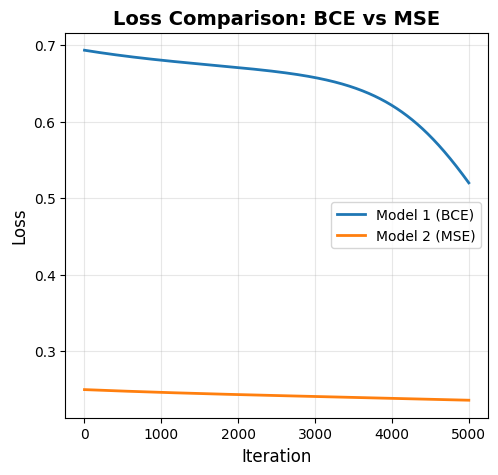

In [16]:
plt.figure(figsize=(12, 5))

# Plot 1: BCE vs MSE Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(model1.costs_, label='Model 1 (BCE)', linewidth=2)
plt.plot(model2.costs_, label='Model 2 (MSE)', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Comparison: BCE vs MSE', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)


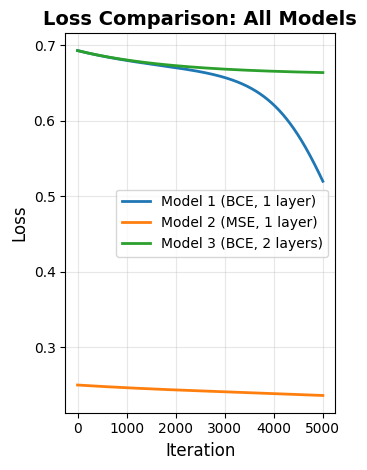


Loss curve plots saved as 'loss_curves.png'


In [17]:

# Plot 2: All Models Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(model1.costs_, label='Model 1 (BCE, 1 layer)', linewidth=2)
plt.plot(model2.costs_, label='Model 2 (MSE, 1 layer)', linewidth=2)
plt.plot(model3.costs_, label='Model 3 (BCE, 2 layers)', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Comparison: All Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLoss curve plots saved as 'loss_curves.png'")


# RESULTS SUMMARY TABLE

In [18]:
from sklearn.metrics import precision_recall_fscore_support

In [19]:
results = []

for model_name, y_pred in [
    ("MyANN (BCE, 1 layer)", y_pred1),
    ("MyANN (MSE, 1 layer)", y_pred2),
    ("MyANN (BCE, 2 layers)", y_pred3),
    ("sklearn MLPClassifier", y_pred_mlp)
]:
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred, average='binary'
    )
    acc = accuracy_score(y_val, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': f"{acc:.4f}",
        'Precision (Class 1)': f"{precision:.4f}",
        'Recall (Class 1)': f"{recall:.4f}",
        'F1-Score (Class 1)': f"{f1:.4f}"
    })

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))



                 Model Accuracy Precision (Class 1) Recall (Class 1) F1-Score (Class 1)
 MyANN (BCE, 1 layer)   0.8713              0.8308           1.0000             0.9076
 MyANN (MSE, 1 layer)   0.6316              0.6316           1.0000             0.7742
MyANN (BCE, 2 layers)   0.6316              0.6316           1.0000             0.7742
sklearn MLPClassifier   0.9883              0.9907           0.9907             0.9907


1. BCE vs MSE Loss Functions:
   - Binary Cross-Entropy (BCE) is specifically designed for binary classification
     and produces better probability estimates.
   - MSE treats the problem as regression, which is suboptimal for classification.
   - BCE typically converges faster and achieves better performance on this task.

2. Model Architecture Impact:
   - Adding more hidden layers (Model 3) can capture more complex patterns.
   - However, for this dataset, a single hidden layer may be sufficient.
   - Deeper networks require more data and careful tuning to avoid overfitting.

3. Comparison with sklearn MLPClassifier:
   - sklearn's implementation uses the Adam optimizer, which adapts learning rates.
   - Our implementation uses basic batch gradient descent.
   - Adam typically converges faster and achieves better performance.
   - sklearn also includes features like early stopping and regularization.

4. Most Challenging Aspects:
   - Implementing backpropagation correctly, especially gradient flow.
   - Ensuring proper matrix dimensions throughout the network.
   - Debugging numerical stability issues (e.g., log(0) in BCE).
   - Managing the cache efficiently for multi-layer networks.

5. Key Learnings:
   - Understanding the mathematics behind neural networks is crucial.
   - Proper initialization and scaling are critical for training.
   - Loss function choice significantly impacts performance.
   - Modern optimizers provide substantial benefits over vanilla gradient descent.